# CNN 활용 보행자 검출

### Import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

### 보행자 학습에 필요한 Positive 데이터를 추출

In [2]:
X_pos = []

pos_filenames = glob.glob('./data/pedestrians128x64/*.ppm')

for i in range(924):
    filename = pos_filenames[i]
    
    # 보행자 이미지 추출
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
        
    # 추출된 이미지를 X 데이터에 담음.
    X_pos.append(img)

### 보행자 이미지 5개 확인

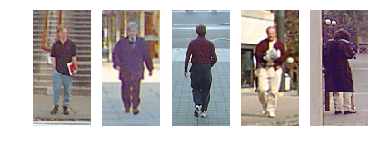

In [3]:
for i in range(5):
    img = X_pos[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### X 데이터 만큼의 개수로 1값으로 세팅된 Y 데이터 생성

In [4]:
X_pos = np.array(X_pos, dtype=np.uint8)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)

### 보행자가 아닌 Negative 데이터를 추출

In [5]:
import os
import random
hroi = 128
wroi = 64

X_neg = []

neg_filenames = glob.glob('data/pedestrians_neg/*.jpg')

for i in range(len(neg_filenames)):
    
    # 보행자 Negative 이미지를 추출
    filename = neg_filenames[i]
    img = cv2.imread(filename)
    # 512x512 사이즈로 변경
    img = cv2.resize(img, (512, 512))
    
    # negative 이미지에서 random으로 128x64이미지를 뽑아 X negative 데이터셋을 뽑느다.
    for j in range(20):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]        
        ### No.
        X_neg.append(roi)

### 추출된 이미지 리스트에서 5개 뽑아 확인

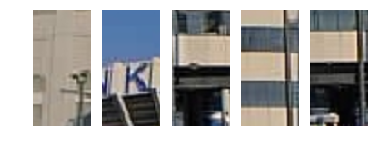

In [6]:
for i in range(5):
    img = X_neg[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### X 데이터 만큼의 개수로 0값으로 세팅된 Y 데이터 생성

In [7]:
X_neg = np.array(X_neg, dtype=np.uint8)
y_neg = np.zeros(X_neg.shape[0], dtype=np.int32)

### Positive 이미지와 Negative 이미지를 합침.

y :  1
y :  1
y :  1
y :  1
y :  0


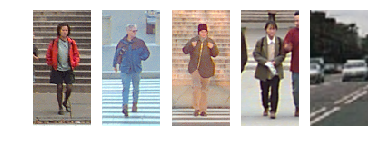

In [8]:
X_datas = np.concatenate((X_pos, X_neg))
y_datas = np.concatenate((y_pos, y_neg))

from sklearn.utils import shuffle

X_datas, y_datas = shuffle(X_datas, y_datas)

import random

for i in range(5):
    img = X_datas[i]
    print('y : ', y_datas[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### Train 데이터셋과 Test 데이터셋으로 나눔.

In [9]:
X_trains = X_datas[:1800]
y_trains = y_datas[:1800]

X_tests = X_datas[1800:]
y_tests = y_datas[1800:]

### Keras 사용하여 학습

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

num_classes = 2

img_rows, img_cols = 128, 64

input_shape = (img_rows, img_cols, 3)

# OneHot Encoding으로 처리. SoftMax로 나온 결과물과 매칭하기 위함.
Y_trains = keras.utils.to_categorical(y_trains, num_classes)
Y_tests = keras.utils.to_categorical(y_tests, num_classes)
    
model = Sequential()
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', 
               kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu', 
               kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu', 
               kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(Dense(2,  activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])



model.fit(X_trains, Y_trains, batch_size=10, epochs=5)

Using TensorFlow backend.


Epoch 1/5
1800/1800 [==============================] - 8s 4ms/step - loss: 0.7233 - acc: 0.5800
Epoch 2/5
1800/1800 [==============================] - 6s 4ms/step - loss: 0.4284 - acc: 0.8433
Epoch 3/5
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3292 - acc: 0.8961
Epoch 4/5
1800/1800 [==============================] - 6s 3ms/step - loss: 0.2634 - acc: 0.9250
Epoch 5/5
1800/1800 [==============================] - 6s 3ms/step - loss: 0.1902 - acc: 0.9389


### 학습 결과 인식률 확인

In [11]:
score = model.evaluate(X_trains, Y_trains)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

1800/1800 [==============================] - 2s 1ms/step
Test loss: 0.09443131105767356
Test accuracy: 0.9816666666666667


### Test Set에서 5개 이미지 테스트

[0 0 0 1 0]


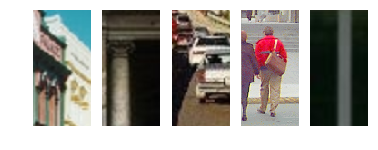

In [12]:
y_prob = model.predict(X_tests[5:10]) 
y_classes = y_prob.argmax(axis=-1)

print(y_classes)
# print(y_tests[-10:])

for i in range(5):
    img = X_tests[i + 5]
#     print('y : ', y_tests[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### model save

In [13]:
model.save('dpcnn.h5')